In [1]:
import numpy as np
import cv2
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.layers import Conv2D, Flatten, MaxPooling2D,Dense,Dropout,SpatialDropout2D
from keras.models  import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import random,os,glob
import matplotlib.pyplot as plt

In [2]:
import zipfile
from google.colab import drive



zip_ref = zipfile.ZipFile("dataset-resized.zip", 'r')
zip_ref.extractall("data")
zip_ref.close()

In [4]:
dir_path = 'data/dataset-resized'

In [5]:
img_list = glob.glob(os.path.join(dir_path, '*/*.jpg'))

In [6]:
len(img_list)

2527

In [7]:
train=ImageDataGenerator(horizontal_flip=True,
                         vertical_flip=True,
                         validation_split=0.1,
                         rescale=1./255,
                         shear_range = 0.1,
                         zoom_range = 0.1,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,)

test=ImageDataGenerator(rescale=1/255,
                        validation_split=0.1)

train_generator=train.flow_from_directory(dir_path,
                                          target_size=(300,300),
                                          batch_size=32,
                                          class_mode='categorical',
                                          subset='training')

test_generator=test.flow_from_directory(dir_path,
                                        target_size=(300,300),
                                        batch_size=32,
                                        class_mode='categorical',
                                        subset='validation')

labels = (train_generator.class_indices)
print(labels)

labels = dict((v,k) for k,v in labels.items())
print(labels)

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
{0: 'cardboard', 1: 'glass', 2: 'metal', 3: 'paper', 4: 'plastic', 5: 'trash'}


In [8]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape

((32, 300, 300, 3), (32, 6))

In [9]:
print (train_generator.class_indices)

Labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(Labels)

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


In [10]:
model=Sequential()
#Convolution blocks

model.add(Conv2D(32,(3,3), padding='same',input_shape=(300,300,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5)) # No accuracy

model.add(Conv2D(64,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 
#model.add(SpatialDropout2D(0.5))

model.add(Conv2D(32,(3,3), padding='same',activation='relu'))
model.add(MaxPooling2D(pool_size=2)) 

#Classification layers
model.add(Flatten())

model.add(Dense(64,activation='relu'))
#model.add(SpatialDropout2D(0.5))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(6,activation='softmax'))

filepath="trained_model.h5"
checkpoint1 = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint1]

In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc']) # RMS PROP - No accuracy

In [12]:
history = model.fit_generator(train_generator,
                              epochs=100,
                              steps_per_epoch=2276//32,
                              validation_data=test_generator,
                              validation_steps=251//32,
                              workers = 4,
                              callbacks=callbacks_list) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
71/71 [==============================] - 334s 5s/step - loss: 1.7800 - acc: 0.1956 - val_loss: 1.6948 - val_acc: 0.2857

Epoch 00001: val_acc improved from -inf to 0.28571, saving model to trained_model.h5
Epoch 2/100
71/71 [==============================] - 332s 5s/step - loss: 1.6516 - acc: 0.2619 - val_loss: 1.5844 - val_acc: 0.3795

Epoch 00002: val_acc improved from 0.28571 to 0.37946, saving model to trained_model.h5
Epoch 3/100
71/71 [==============================] - 332s 5s/step - loss: 1.5778 - acc: 0.3327 - val_loss: 1.5278 - val_acc: 0.3884

Epoch 00003: val_acc improved from 0.37946 to 0.38839, saving model to trained_model.h5
Epoch 4/100
71/71 [==============================] - 332s 5s/step - loss: 1.5393 - acc: 0.3613 - val_loss: 1.4853 - val_acc: 0.4241

Epoch 00004: val_acc improved from 0.38839 to 0.42411, saving model to trained_model.h5
Epoch 5/100
71/71 [==============================] - 331s 5s/step - loss: 1.4676 - acc: 0.3858 - val_loss: 1.4266 - val

Maximum Probability:  0.9797611
Classified: paper


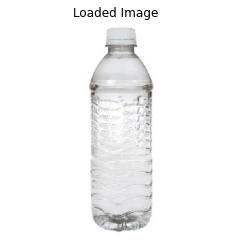

In [13]:

from keras.preprocessing import image

img_path = 'bottle.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)

Maximum Probability:  0.9997266
Classified: plastic


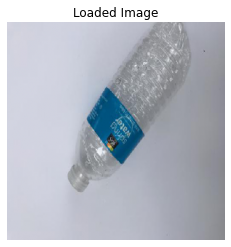

In [14]:

from keras.preprocessing import image

img_path = 'data/dataset-resized/plastic/plastic75.jpg'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img, dtype=np.uint8)
img=np.array(img)/255.0

plt.title("Loaded Image")
plt.axis('off')
plt.imshow(img.squeeze())

p=model.predict(img[np.newaxis, ...])

#print("Predicted shape",p.shape)
print("Maximum Probability: ",np.max(p[0], axis=-1))
predicted_class = labels[np.argmax(p[0], axis=-1)]
print("Classified:",predicted_class)


-------------------Individual Probability--------------------------------

CARDBOARD : 0.0 %
GLASS : 0.03 %
METAL : 0.0 %
PAPER : 0.0 %
PLASTIC : 99.97 %
TRASH : 0.0 %


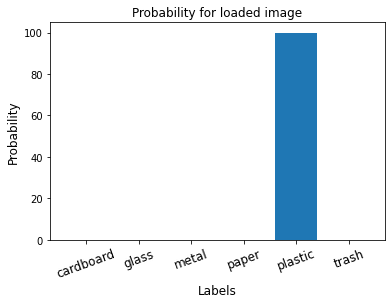

In [15]:
classes=[]
prob=[]
print("\n-------------------Individual Probability--------------------------------\n")

for i,j in enumerate (p[0],0):
    print(labels[i].upper(),':',round(j*100,2),'%')
    classes.append(labels[i])
    prob.append(round(j*100,2))
    
def plot_bar_x():
    # this is for plotting purpose
    index = np.arange(len(classes))
    plt.bar(index, prob)
    plt.xlabel('Labels', fontsize=12)
    plt.ylabel('Probability', fontsize=12)
    plt.xticks(index, classes, fontsize=12, rotation=20)
    plt.title('Probability for loaded image')
    plt.show()
plot_bar_x()

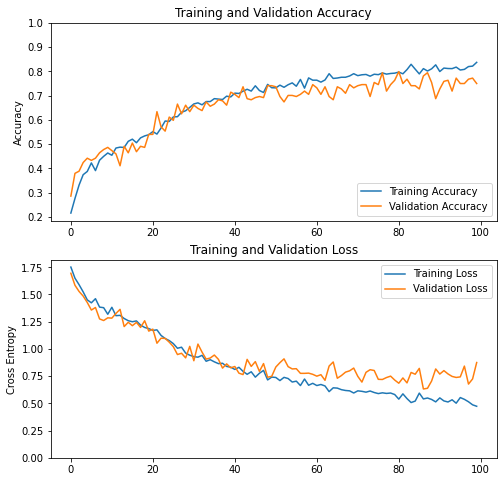

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [25]:
import tensorflow as tf

model = tf.keras.models.load_model( 'Garbage.h5' )

converter = tf.lite.TFLiteConverter.from_keras_model( model )
tflite_model = converter.convert()
open("garbage.tflite", "wb").write(tflite_model)  

INFO:tensorflow:Assets written to: /tmp/tmpnf3cjrl8/assets


11379808